In [22]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! wget -O ./words.zip 'https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt' 

! tar -xzf text_files.tar.gz
! pip install unidecode
! pip install torch

--2018-10-12 18:11:23--  https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz
Resolving piazza.com (piazza.com)... 34.237.217.71, 34.200.202.18, 52.20.136.189, ...
Connecting to piazza.com (piazza.com)|34.237.217.71|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://d1b10bmlvqabco.cloudfront.net/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz [following]
--2018-10-12 18:11:23--  https://d1b10bmlvqabco.cloudfront.net/attach/jlifkda6h0x5bk/hzosotq4zil49m/jn13x09arfeb/text_files.tar.gz
Resolving d1b10bmlvqabco.cloudfront.net (d1b10bmlvqabco.cloudfront.net)... 13.33.227.25, 13.33.227.180, 13.33.227.29, ...
Connecting to d1b10bmlvqabco.cloudfront.net (d1b10bmlvqabco.cloudfront.net)|13.33.227.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1533290 (1.5M) [application/x-gzip]
Saving to: ‘./text_files.tar.gz’

./text_files.tar.gz 100%[

In [60]:
import unidecode
import string
import random
import re
 
import pdb
 
all_characters = string.printable
n_characters = len(all_characters)
 
file = unidecode.unidecode(open('./text_files/alma.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 466656


In [0]:
file2=open('./words.zip')
words =''
for i in file2:
  if i[0] in ['a', 'A']:
    words+=i


The text I chose to train it on is the dictionary, with all words not starting with A cut out. This is because the dictionary has a very specific, hopefully learnable structure. Things I'm hoping it learns: all words start with a, all words followed by a new line, and ideally, words are followed by words that are extremely similar (usually first 3 or 4 letters are the same). Alphabetical ordering is also nice but I'm not sure a 1 character at a time is capable of learning how to alphabetize. 

In [69]:
chunk_len = 200
 
def random_chunk(file):
    file_len= len(file)
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]
 
print(random_chunk(file))

he king, that we were sure our forces were sufficient to take the city of Antiparah by our force; and by delivering up the prisoners for that city we should suppose ourselves unwise, and that we would 


In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)
 
print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [0]:
def random_training_set(file):    
    chunk = random_chunk(file)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target


In [0]:
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers):
    super(GRU, self).__init__()
    self.input_size=input_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    
    self.weight_ih = torch.zeros(3*hidden_size, input_size)
    self.weight_hh = torch.zeros(3*hidden_size, hidden_size)
    self.bias_ih = torch.zeros(3*hidden_size)
    self.bias_hh = torch.zeros(3*hidden_size)
    
    #Not finished
  def forward(self, input_char, h0):
    r = nn.sigmoid(self.weight_ih.matmul(input_char)+self.bias_ih+self.bias_hh.matmul(h0))
    z= nn.sigmoid()
    return(input_char, h0)
  
  

In [0]:

 
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.gru = nn.GRU(1, self.hidden_size, self.n_layers)
        self.linear = nn.Linear(hidden_size, 100)
        
        # encode using embedding layer
        # set up GRU passing in number of layers parameter (nn.GRU)
        # decode output
 
    def forward(self, input_char, hidden):
        # by reviewing the documentation, construct a forward function that properly uses the output
        # of the GRU
        # return output and hidden
        #print(input_char.unsqueeze(0).size())
        #print(hidden.size())
        
        output, hidden =self.gru(input_char.unsqueeze(0).unsqueeze(0).unsqueeze(0).float(), hidden)
        return(self.linear(output), hidden)
 
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
    

In [0]:
def train(inp, target):
    ## initialize hidden layers, set up gradient and loss 
      # your code here
    ## /
    decoder_optimizer.zero_grad()
    loss = 0

    hidden= decoder.init_hidden()
    #print(hidden.size())
    for c in range(chunk_len):
        #print(inp[c])
        output, hidden = decoder(inp[c], hidden) # run the forward pass of your rnn with proper input
        #pdb.set_trace()
        loss += criterion(output.squeeze(0), target[c].unsqueeze(0))
    ## calculate backwards loss and step the optimizer (globally)
      # your code here
    ## /
    loss.backward()
    decoder_optimizer.step()
 
    return loss.item() / chunk_len

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    ## initialize hidden variable, initialize other useful variables 
      # your code here
    ## /
 
    prime_input = char_tensor(prime_str)
    hidden = decoder.init_hidden()
    #pdb.set_trace()
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str)):
      #print(p)
      _, hidden = decoder(prime_input[p], hidden)
      #print(hidden)  
    #pdb.set_trace()
    inp = prime_input[-1]
    predicted=prime_str
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)#run your RNN/decoder forward on the input
        #print(output.size(), hidden.size())
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        inp=top_i
        #print(top_i)
        predicted += all_characters[top_i.item()]
        ## get character from your list of all characters, add it to your output str sequence, set input
        ## for the next pass through the model
         # your code here
        ## /
 
    return predicted

In [59]:
import time
n_epochs = 4000
print_every = 1000
plot_every=20
hidden_size = 120
n_layers = 1
lr = 0.005
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
#for i in decoder.parameters():
 # print(i.size())
start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss_ = train(*random_training_set(words))   
    loss_avg += loss_
 
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
        print(evaluate('account\naccountability\naccountable\naccountableness\naccountably', 100, temperature=1), '\n')
 
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[175.32519364356995 (1000 25%) 2.3775]
account
accountability
accountable
accountableness
accountably
anacau
artssiyacnleynssasy
abgbsfl
aciiiue
acbtynfocpes
anpprhdeere
artierurs
atpsooieb
agemogl
art 

[350.85845470428467 (2000 50%) 2.4992]
account
accountability
accountable
accountableness
accountablys
alcloataclttad
acloitnav
ablluir
attactoa
acacgtaysiammg
apsebloo
adaebnar
aleiegmmio
adeoctidz
af 

[527.4802129268646 (3000 75%) 2.2651]
account
accountability
accountable
accountableness
accountablymc
abaccygd
aabeoimable
abnacveg
anbtb
aaam
abcattis
abarsa
agacri
abgoicdss
abavsascoer
accabiyla
a 

[705.0368611812592 (4000 100%) 2.4319]
account
accountability
accountable
accountableness
accountablyab
acdzlne
adgesne
munod
acer
abgr
afl
aceld
abento
asla
abifa
aberog
achgiaee
acdeig
aceezfef
abbts 



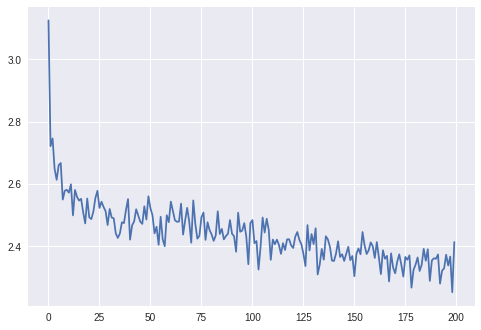

# 1
account
accountability
accountable
accountableness
accountably
aceln
agdalem
aceiise
adeco
abeedl
adoadls
acedeel
agedelle
agbia
abeoils
ablier
adezebl
aceex
acat 

# 2
account
accountability
accountable
accountableness
accountablyg
aciedel
abeln
abele
abe
adggls
abe
adc
abeneor
abeocs
abeaate
acecletr
abeates
abeie
adoned
adee
a 

# 3
account
accountability
accountable
accountableness
accountably
abboo
adao
abeie
adeae
acbdlienn
agengdle
abcleeal
abdrl
abo
abeoiu
acrcs
adadeel
aberns
abbu
aberi 

# 4
account
accountability
accountable
accountableness
accountably
abecols
abeudcs
abehelte
acnarelois
abebo
abdu
abet
aceano
abrgdu
abcere
adeirge
aciriss
acieiee
ab 

# 5
account
accountability
accountable
accountableness
accountably
aceeholi
abea
abdcoo
abeii
acdd
abceet
aceetie
abertecu
abee
abe
acere
accedves
abcen
adete
abges
a 

# 6
assail
assailability
assailable
assailableness
assailant
assailants
artii
astizast
antetrie
anririnlcx
ausecdtr
avtecssarea
abreenlde
abriac
abneros
as

In [67]:
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

for i in range(5):
  print("#", i+1)
  print(evaluate("account\naccountability\naccountable\naccountableness\naccountably", 100, .8), '\n')

for i in range(5):
  print("#", i+6)
  print(evaluate("assail\nassailability\nassailable\nassailableness\nassailant\nassailants", 100, .8), '\n')
  
#What happends if I give it nonsense to build up on?
for i in range(5):
  print("#", i+11)
  print(evaluate("gilding\ngildings\ngilds\ngildship\ngildsman\ngildsmen", 100, .8),'\n')

Interestingly, the network shows signs of learning the letters around the correct letter. So if I'm doing "acc" words, the words are much more likely to be "ab" words or "ad" words than if I started with "As"

In [75]:
n_epochs = 40000
print_every = 10000
plot_every=100
hidden_size = 120
n_layers = 1
lr = 0.005
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
#for i in decoder.parameters():
 # print(i.size())
start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss_ = train(*random_training_set(file))   
    loss_avg += loss_
 
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
        print(evaluate('I, Alma, having been commanded of G', 100, temperature=1), '\n')
 
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[1781.6388437747955 (10000 25%) 2.6794]
I, Alma, having been commanded of Gsporeteshshs this, and alp eamh ii Jords clal camosen wotok aro thall asaenec their wouns aieen of g 

[3573.8117921352386 (20000 50%) 2.0156]
I, Alma, having been commanded of Goewiiiens; domde,

 N Ahat Iodsgs bre thould had oenuld bymweeted of Joredmw, they witte bll beann t 



KeyboardInterrupt: ignored

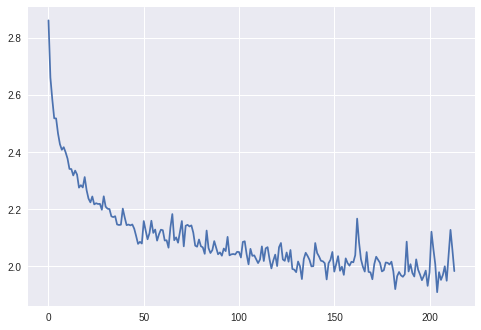

# 1
ye shall prosper i tito the cllnl she chees the co aelint the leatin in thich oo hi cailentuerlanis of Gor ht God, aea
# 2
ye shall prosper im the fsiee in Gamanine whti foeat in cauhadren theie pheie alo the pecddfon an caw as aly of mes ai
# 3
ye shall prosper i fasserole to mot pefth aehin oot of aioyhed wito the coneenanine oas ar are tase tosd tocting, case
# 4
ye shall prosper i was te tasue wptd sotoe, y ray ay lf Gerhet aiayiens dopedrd yas see tod ceasteus of their wiat tor
# 5
ye shall prosper i of the people eall ueioldt, areat to tiicr woulse yor foeyanter that delen amldte aelnte wesi te ta
# 6
I am Malh. aehodd aetalen Aie we hand of allinest, aedause the ptpkner cepiny. aeennd, 
 And to hn toereh
# 7
I am asannnds. 
 Ood we tioc ae fac tay she proroet ae dor has ae wiitl comter to papua nut pnt of Gepit 
# 8
I am alro theied has toiamen so daltrknen- 
 And tlto ttr,
therefore sakemnd hn cauhen,-coomte aestee the
# 9
I am uat foser tonpld rhiired of Iepth uho Iamanity

In [76]:
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

for i in range(5):
  print("#", i+1)
  print(evaluate("ye shall prosper i", 100, .8))

for i in range(5):
  print("#", i+6)

  print(evaluate("I am ", 100, .8))
  
for i in range(5):
  print("#", i+11)
  print(evaluate("t came to p", 100, .8))